# Generación datos faltantes

## Inicio

Este notebook sirve para generar datos faltantes en un dataset completo

In [41]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
warnings.filterwarnings('ignore', category=SyntaxWarning)  # Porque el \d de \data y \daily lo toma como un valor especial
dataframe = pd.read_csv("..\data\daily-minimum-temperatures-in-me.csv", header=0, index_col=0, parse_dates=True)
series = dataframe.squeeze('columns')
series.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\alaba\AppData\Local\Temp\ipykernel_17048\1061710041.py:2: SyntaxWarning: invalid escape sequence '\d'
  dataframe = pd.read_csv("..\data\daily-minimum-temperatures-in-me.csv", header=0, index_col=0, parse_dates=True)


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Lo pasamos a float

In [3]:
series = series.astype(float)
series.dtypes

dtype('float64')

Dibujamos

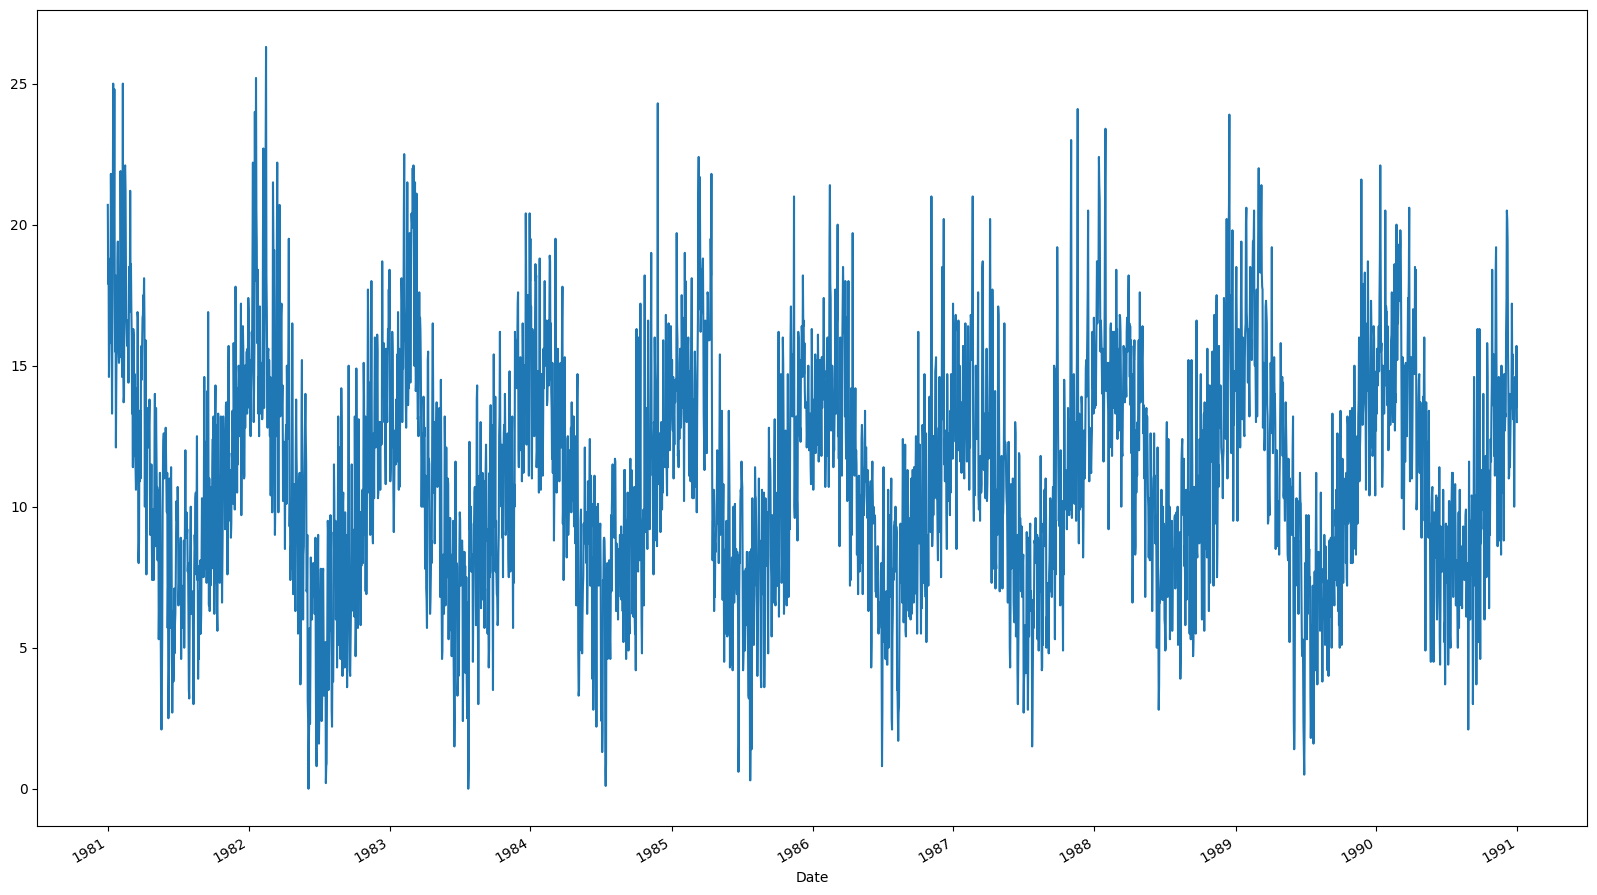

In [4]:
series.plot(figsize=(20,12))
plt.show()

Comprobamos que no haya nulos

c:\Users\alaba\Importante\4º Carrera\TFG\WorkspaceTFG\env\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


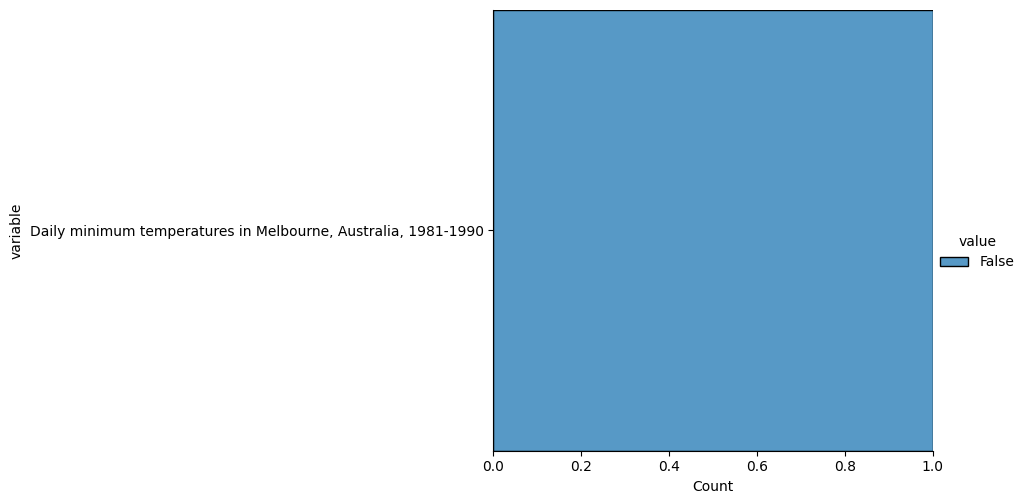

In [5]:
dataframe.isnull().melt().pipe(lambda df: (sns.displot(data=df, y='variable', hue='value', multiple='fill')))

Comprobamos si están todos los días

In [6]:
series = series.resample('D').mean()
series[series.isna()]

Date
1984-12-31   NaN
1988-12-31   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Solo hay 2, los podemos imputar a mano ya que son pocos, conocemos donde estan y sus valores cercanos, y no tendrán casi ningún impacto en el resultado del dataset

In [28]:
series['1984-12-31'] = (series['1984-12-30'] + series['1985-01-01'])/2
print(series['1984-12-31'])

series['1988-12-31'] = (series['1988-12-30'] + series['1989-01-01'])/2
print(series['1988-12-31'])

14.85
14.2


## Funciones auxiliares

### Graficar con nulos

In [36]:
def dibuja_datos(serie):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(20, 12))

    # Dibujar la serie temporal
    ax.plot(serie.index, serie.values, color='blue')

    # Dibujar líneas verticales rojas para los valores nulos
    null_dates = serie[serie.isna()].index
    for date in null_dates:
        ax.axvline(x=date, color='red', linestyle='-', alpha=0.5)

    # Configurar el gráfico
    ax.set_title('Serie Temporal con Marcadores de Valores Nulos')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.grid(True)

    # Rotar las etiquetas del eje x para mejor legibilidad
    plt.xticks(rotation=45)

    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()


### Eliminar datos consecutivos

In [66]:
def eliminar_consecutivos(serie, indices, n_eliminar, min, max):
    while len(serie[serie.isna()]) < n_eliminar:
        i = random.choice(indices)
        diferencia = n_eliminar - len(serie[serie.isna()])
        if diferencia < max:
            numero_aleatorio = random.randint(min, diferencia)
        else:
            numero_aleatorio = random.randint(min, max)
        inicio = serie.index.get_loc(i)
        final = serie.index.get_loc(i)+numero_aleatorio
        if final >= len(serie):
            inicio -= numero_aleatorio
            final -= numero_aleatorio
        serie.iloc[inicio:final] = np.nan
    return serie

## Insertar nulos en puntos aleatorios

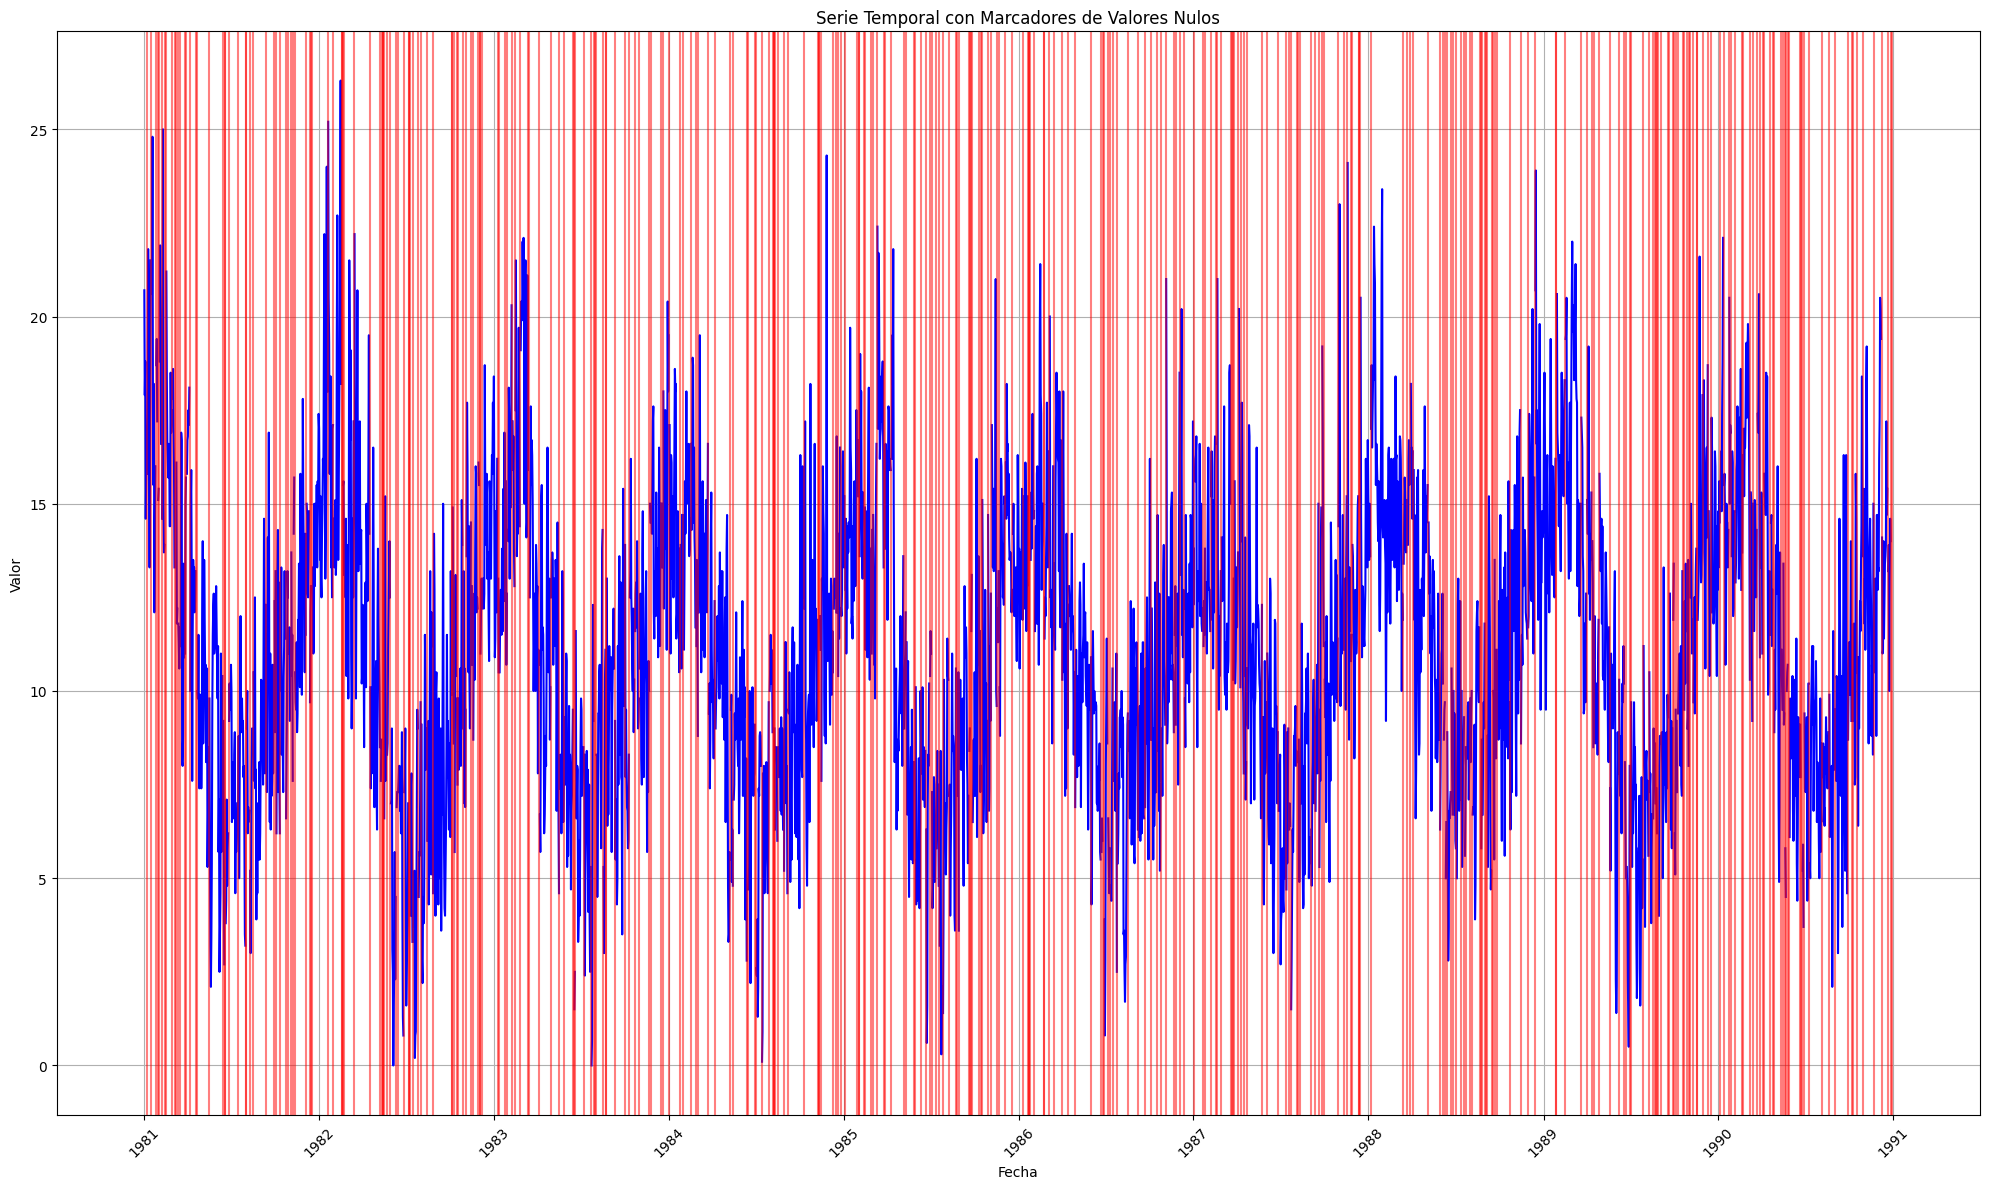

In [ ]:
np.random.seed(27) # para tener resultados repetibles
porcentaje = 0.1

serie_nulos_aleatorios = series.copy()

n_eliminar = int(len(series) * porcentaje)

indices_a_eliminar = np.random.choice(series.index, size=n_eliminar, replace=False)

serie_nulos_aleatorios.loc[indices_a_eliminar] = np.nan

dibuja_datos(serie_nulos_aleatorios)

In [ ]:
serie_nulos_aleatorios[serie_nulos_aleatorios.isna()]

365

## Simulación fallo por batería

La intencion es eliminar tramos de unos 20 dias seguidos. Para ello, hacemos que los numeros a eliminar se dividan entre 20 (o lo que es lo mismo, multiplicar por 0.05), lo que nos da los indices desde los cuales tenemos que eliminar. Dese cada índice eliminamos los siguientes 20 dias.

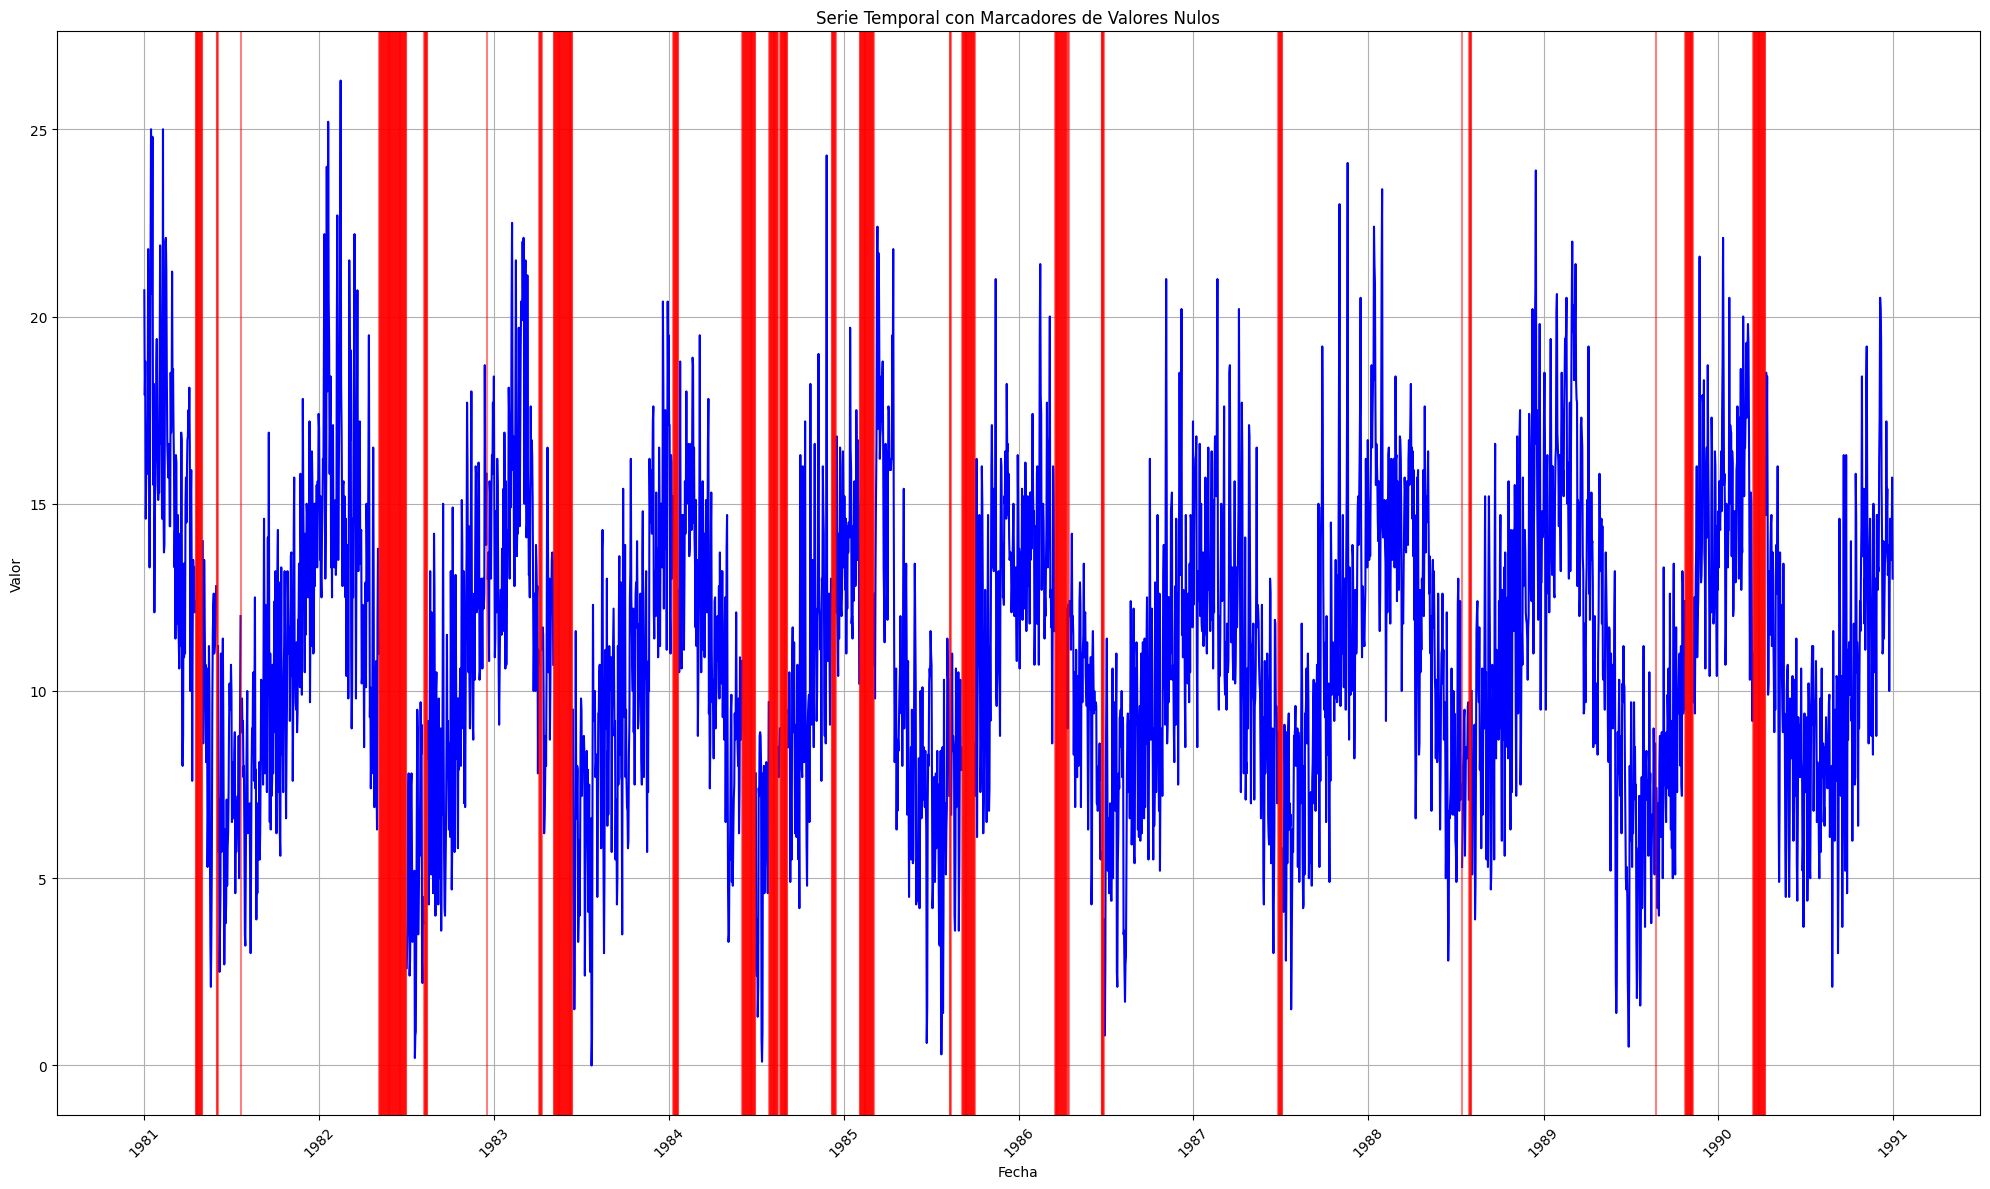

In [ ]:
np.random.seed(27) # para tener resultados repetibles
random.seed(27) # para tener resultados repetibles
porcentaje = 0.1
min = 1
max = 30
#divisiones = 0.05

serie_nulos_seguidos = series.copy()

n_eliminar = int(len(series) * porcentaje)
n_eliminar_inicio = int(n_eliminar*0.75)
serie_nulos_seguidos_inicio = serie_nulos_seguidos.iloc[0:int(len(serie_nulos_seguidos)/2)]
serie_nulos_seguidos_final = serie_nulos_seguidos.iloc[int(len(serie_nulos_seguidos)/2):len(serie_nulos_seguidos)]

#indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar*divisiones), replace=False)
"""
for i in range (0, len(indices_a_eliminar)):
    inicio = serie_nulos_seguidos.index.get_loc(indices_a_eliminar[i])
    final = serie_nulos_seguidos.index.get_loc(indices_a_eliminar[i])+int(1/divisiones)+1
    if final >= len(serie_nulos_seguidos):
        inicio -= int(1/divisiones)+1
        final -= int(1/divisiones)+1
    serie_nulos_seguidos.iloc[inicio:final] = np.nan
dibuja_datos(serie_nulos_seguidos)
"""
serie_nulos_seguidos = eliminar_consecutivos(serie_nulos_seguidos, serie_nulos_seguidos_inicio.index, n_eliminar_inicio, min, max)
serie_nulos_seguidos = eliminar_consecutivos(serie_nulos_seguidos, serie_nulos_seguidos_final.index, n_eliminar, min, max)
dibuja_datos(serie_nulos_seguidos)


In [70]:
serie_nulos_seguidos[serie_nulos_seguidos.isna()]

Date
1981-04-18   NaN
1981-04-19   NaN
1981-04-20   NaN
1981-04-21   NaN
1981-04-22   NaN
              ..
1990-04-05   NaN
1990-04-06   NaN
1990-04-07   NaN
1990-04-08   NaN
1990-04-09   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 365, dtype: float64

## Simulación por fallo de interferencia

### Fallos pequeños distribuidos por todo el dataset

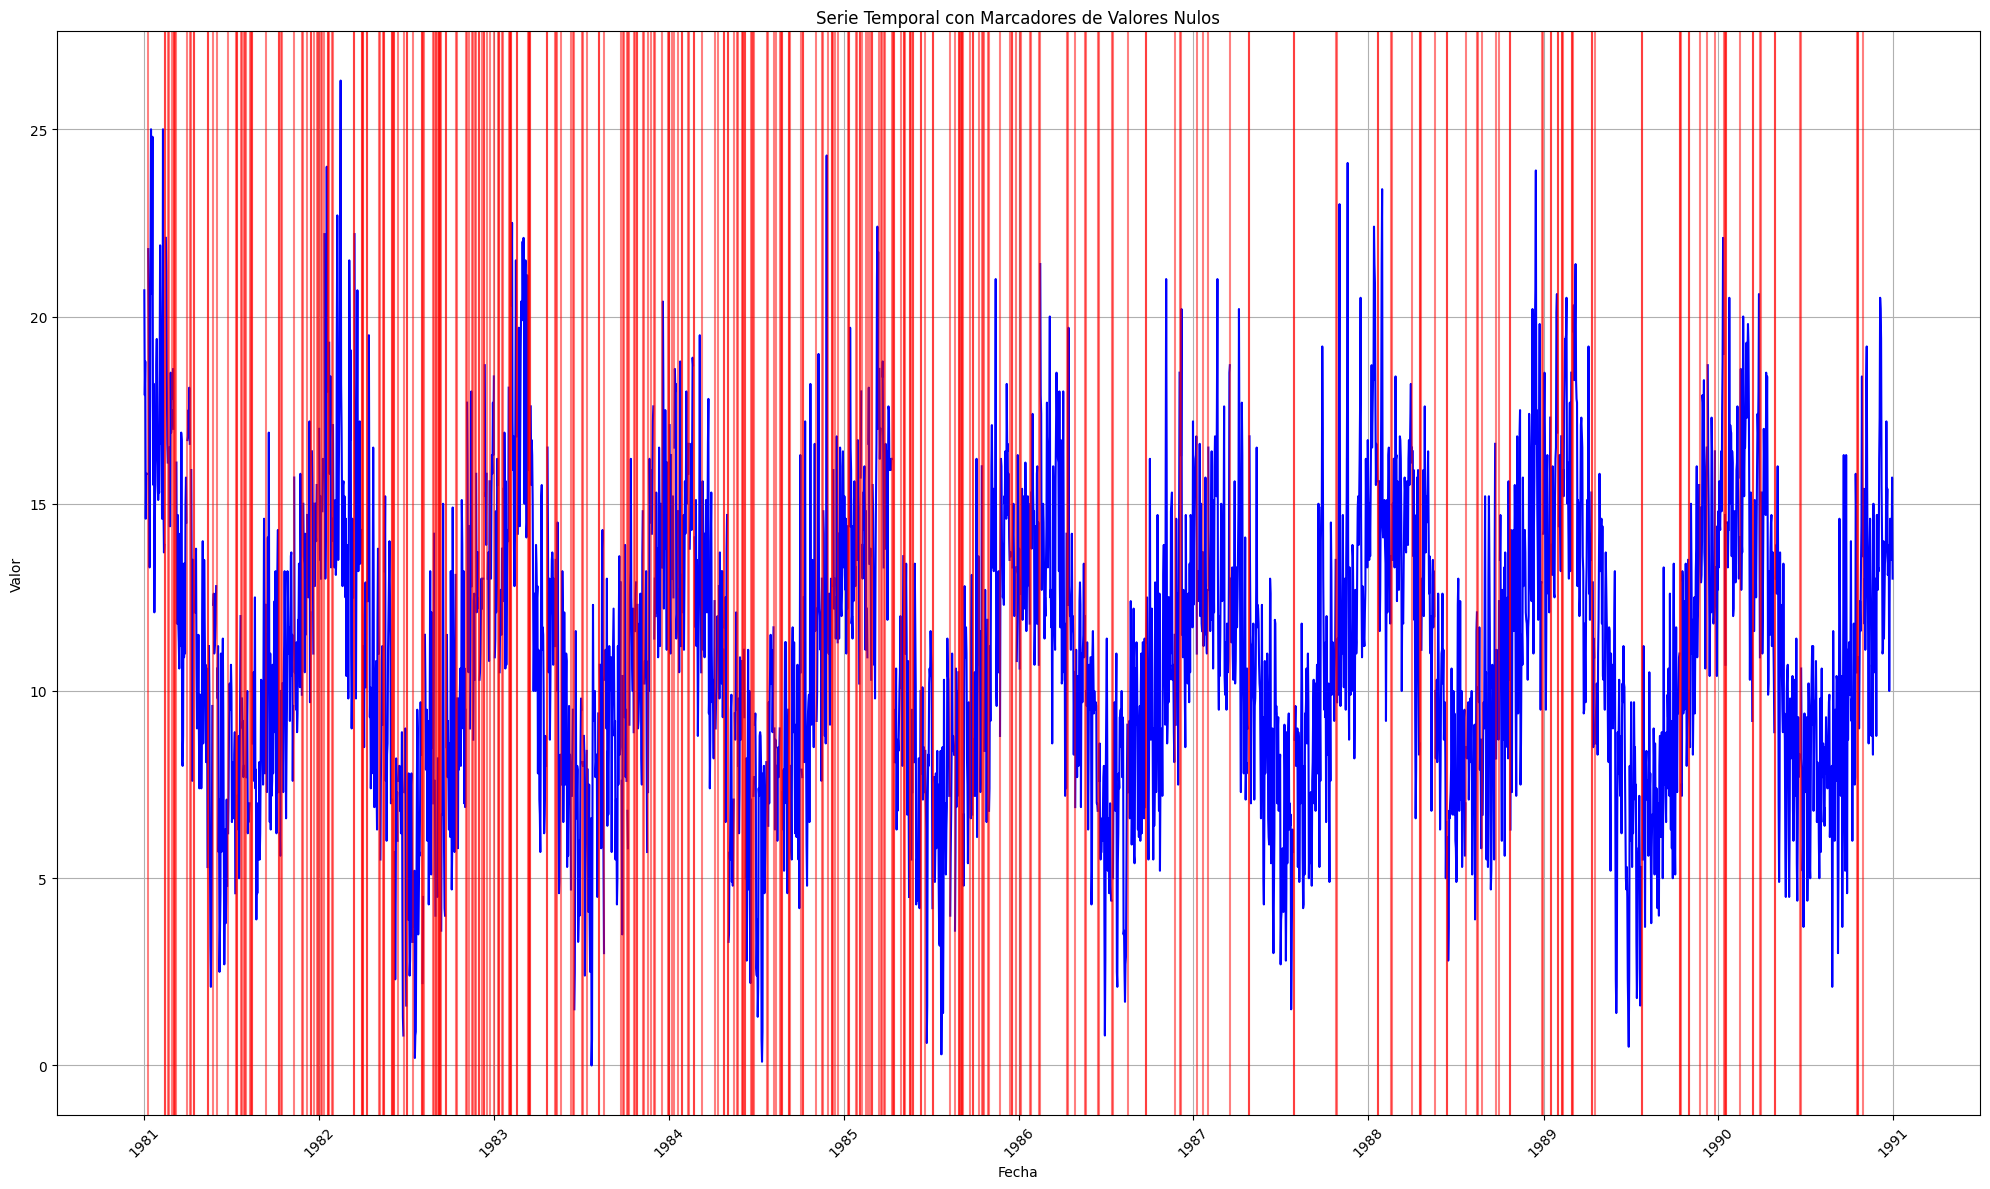

In [71]:
random.seed(27) # para tener resultados repetibles
porcentaje = 0.1
min = 1
max = 2

serie_nulos_interferencias = series.copy()

n_eliminar = int(len(series) * porcentaje)
n_eliminar_inicio = int(n_eliminar*0.75)
serie_nulos_interferencias_inicio = serie_nulos_interferencias.iloc[0:int(len(serie_nulos_interferencias)/2)]
serie_nulos_interferencias_final = serie_nulos_interferencias.iloc[int(len(serie_nulos_interferencias)/2):len(serie_nulos_interferencias)]

serie_nulos_interferencias = eliminar_consecutivos(serie_nulos_interferencias, serie_nulos_interferencias_inicio.index, n_eliminar_inicio, min, max)
serie_nulos_interferencias = eliminar_consecutivos(serie_nulos_interferencias, serie_nulos_interferencias_final.index, n_eliminar, min, max)

dibuja_datos(serie_nulos_interferencias)

In [72]:
serie_nulos_seguidos[serie_nulos_seguidos.isna()]

Date
1981-04-18   NaN
1981-04-19   NaN
1981-04-20   NaN
1981-04-21   NaN
1981-04-22   NaN
              ..
1990-04-05   NaN
1990-04-06   NaN
1990-04-07   NaN
1990-04-08   NaN
1990-04-09   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 365, dtype: float64

## Insertar nulos discontinuos

Parecido al anterior pero esta vez se cogen periodos de 60 dias y se elimina uno de cada 3

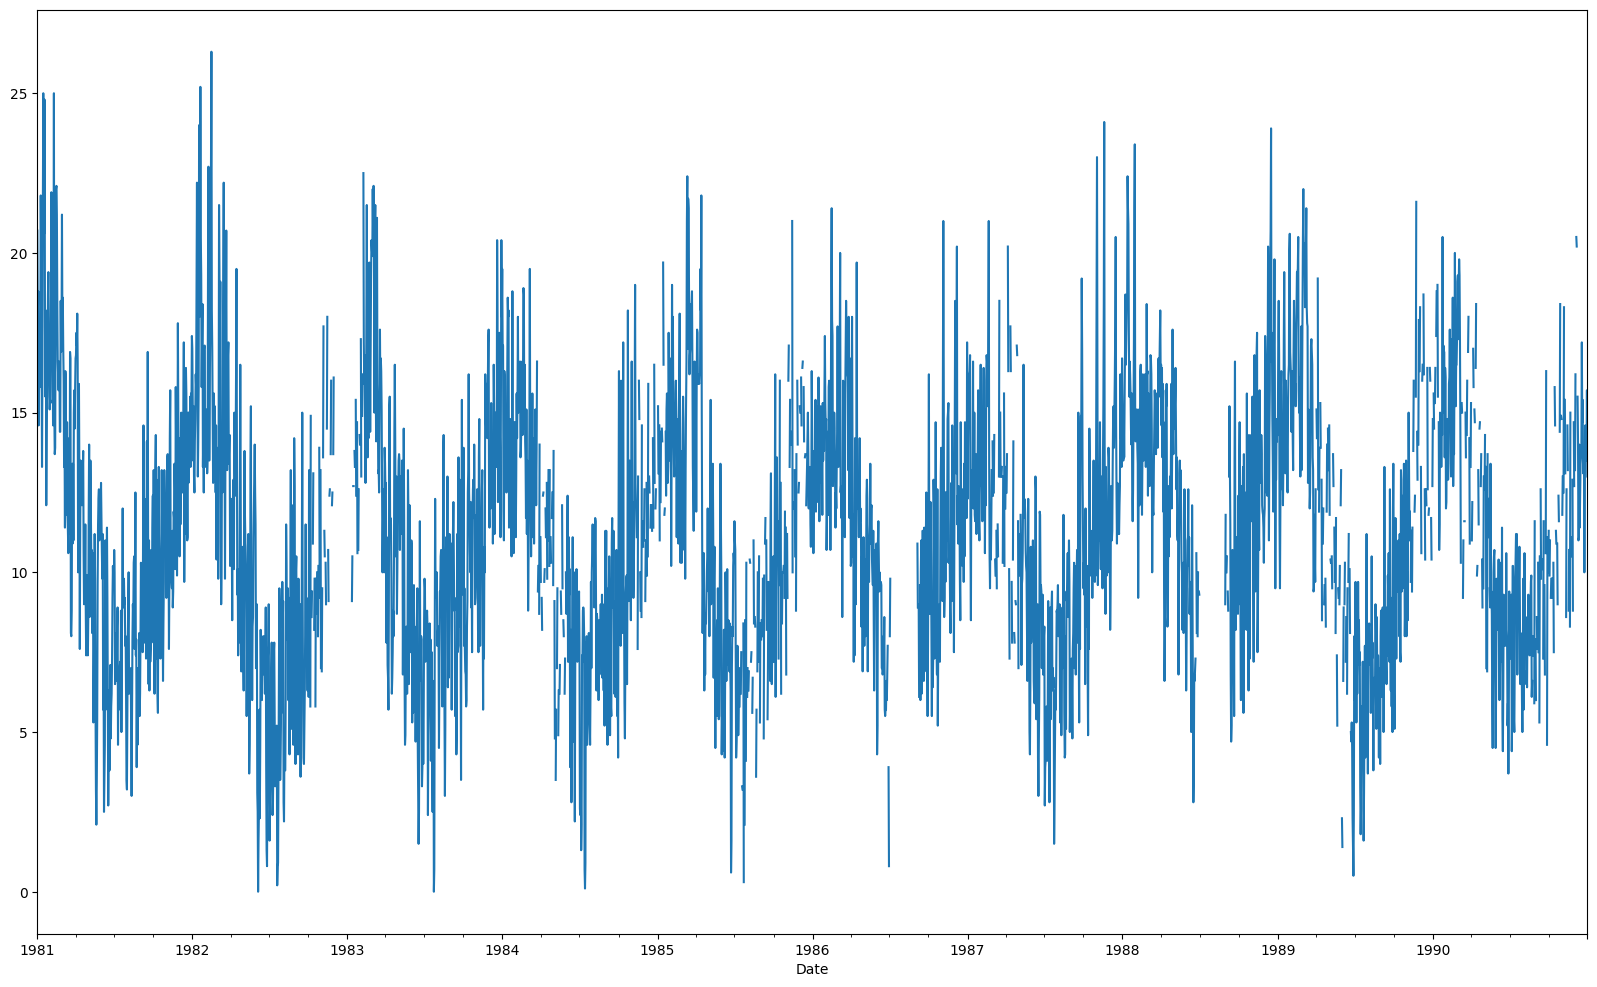

In [13]:
np.random.seed(27) # para tener resultados repetibles
porcentaje = 0.1
divisiones = 0.05

serie_nulos_discontinuos = series.copy()

n_eliminar = int(len(series) * porcentaje)

indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar*divisiones), replace=False)
for i in range (0, len(indices_a_eliminar)):
    inicio = serie_nulos_discontinuos.index.get_loc(indices_a_eliminar[i])
    final = serie_nulos_discontinuos.index.get_loc(indices_a_eliminar[i])+int(1/divisiones)*3+7
    if final>=len(serie_nulos_discontinuos):
        inicio -= int(1/divisiones)*3+7
        final -= int(1/divisiones)*3+7
    for j in range(inicio,final,3):
        serie_nulos_discontinuos.iloc[j] = np.nan
serie_nulos_discontinuos.plot(figsize=(20,12))
plt.show()

Se ve que se elimina uno de cada 3. Y que la cantidad de eliminados ronda el porcentaje deseado

In [14]:
serie_nulos_discontinuos[serie_nulos_discontinuos.isna()]

Date
1982-10-05   NaN
1982-10-08   NaN
1982-10-11   NaN
1982-10-14   NaN
1982-10-17   NaN
              ..
1990-11-25   NaN
1990-11-28   NaN
1990-12-01   NaN
1990-12-04   NaN
1990-12-07   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 375, dtype: float64

Aqui se ve un mes concreto

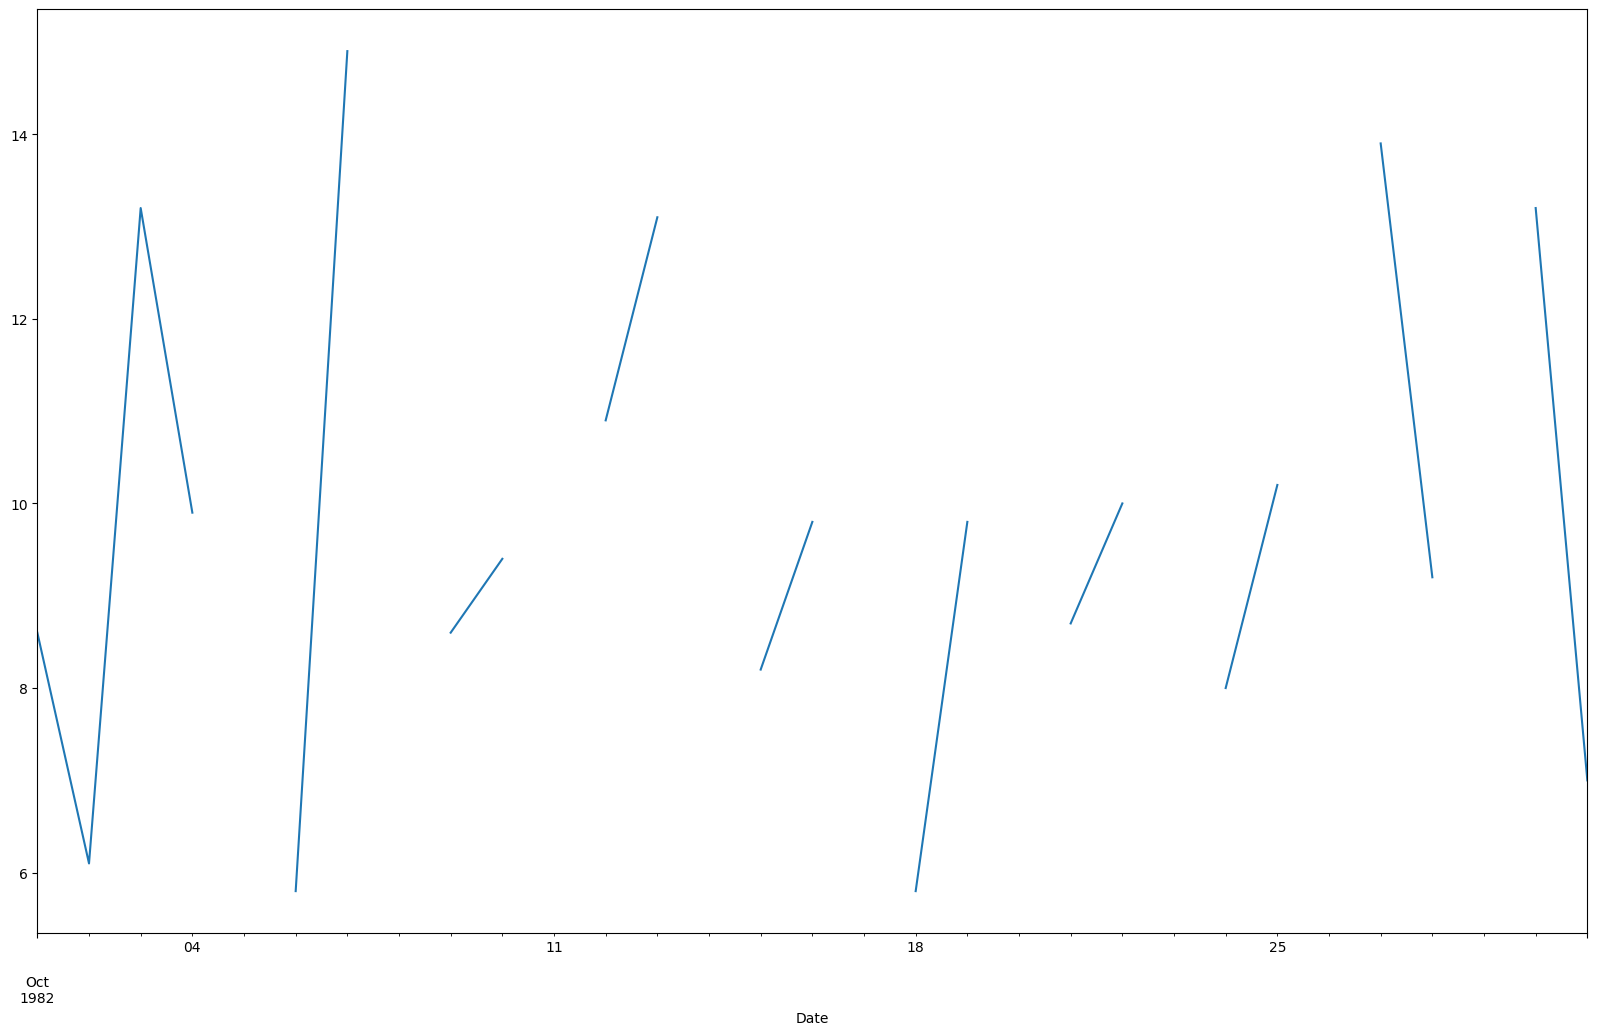

In [15]:
serie_nulos_discontinuos['1982-10'].plot(figsize=(20,12))
plt.show()

## Insertar nulos al inicio y al final

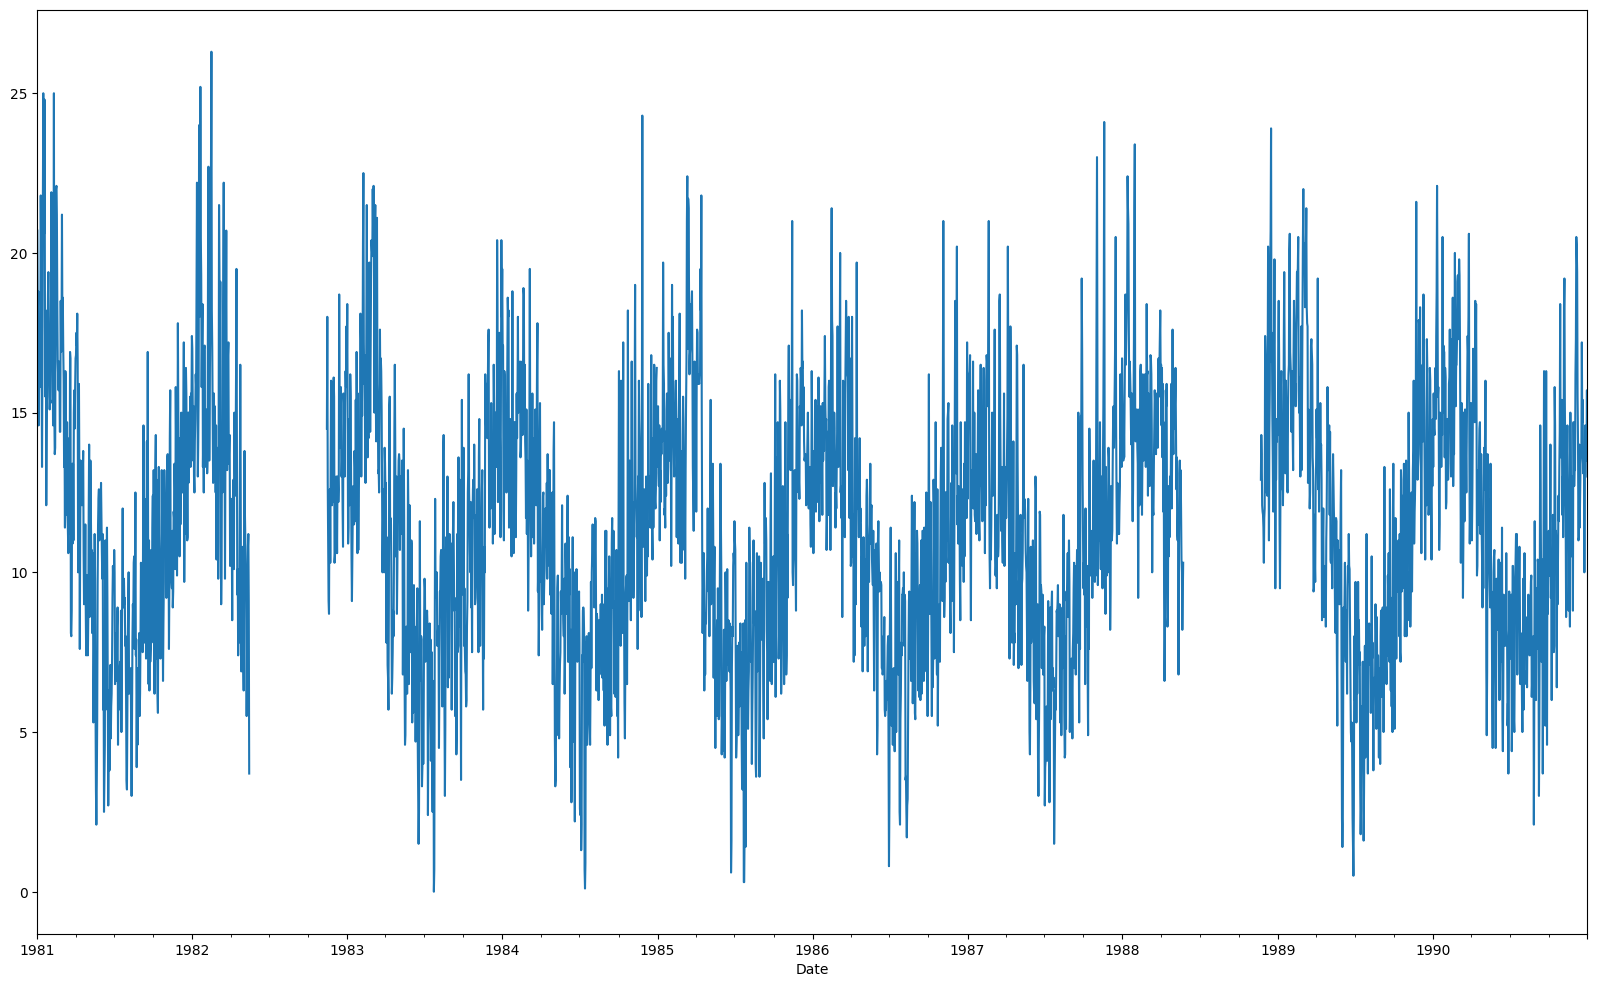

In [16]:
porcentaje = 0.1

serie_nulos_inifi = series.copy()

n_eliminar = int(len(series) * porcentaje)

serie_nulos_inifi.iloc[500:500+int(n_eliminar/2)] = np.nan # Eliminar unos datos del inicio
serie_nulos_inifi.iloc[2700:2700+int(n_eliminar/2)] = np.nan # Eliminar unos datos del final

serie_nulos_inifi.plot(figsize=(20,12))
plt.show()

In [17]:
serie_nulos_inifi[serie_nulos_inifi.isna()]

Date
1982-05-16   NaN
1982-05-17   NaN
1982-05-18   NaN
1982-05-19   NaN
1982-05-20   NaN
              ..
1988-11-18   NaN
1988-11-19   NaN
1988-11-20   NaN
1988-11-21   NaN
1988-12-31   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 366, dtype: float64

## Todo junto

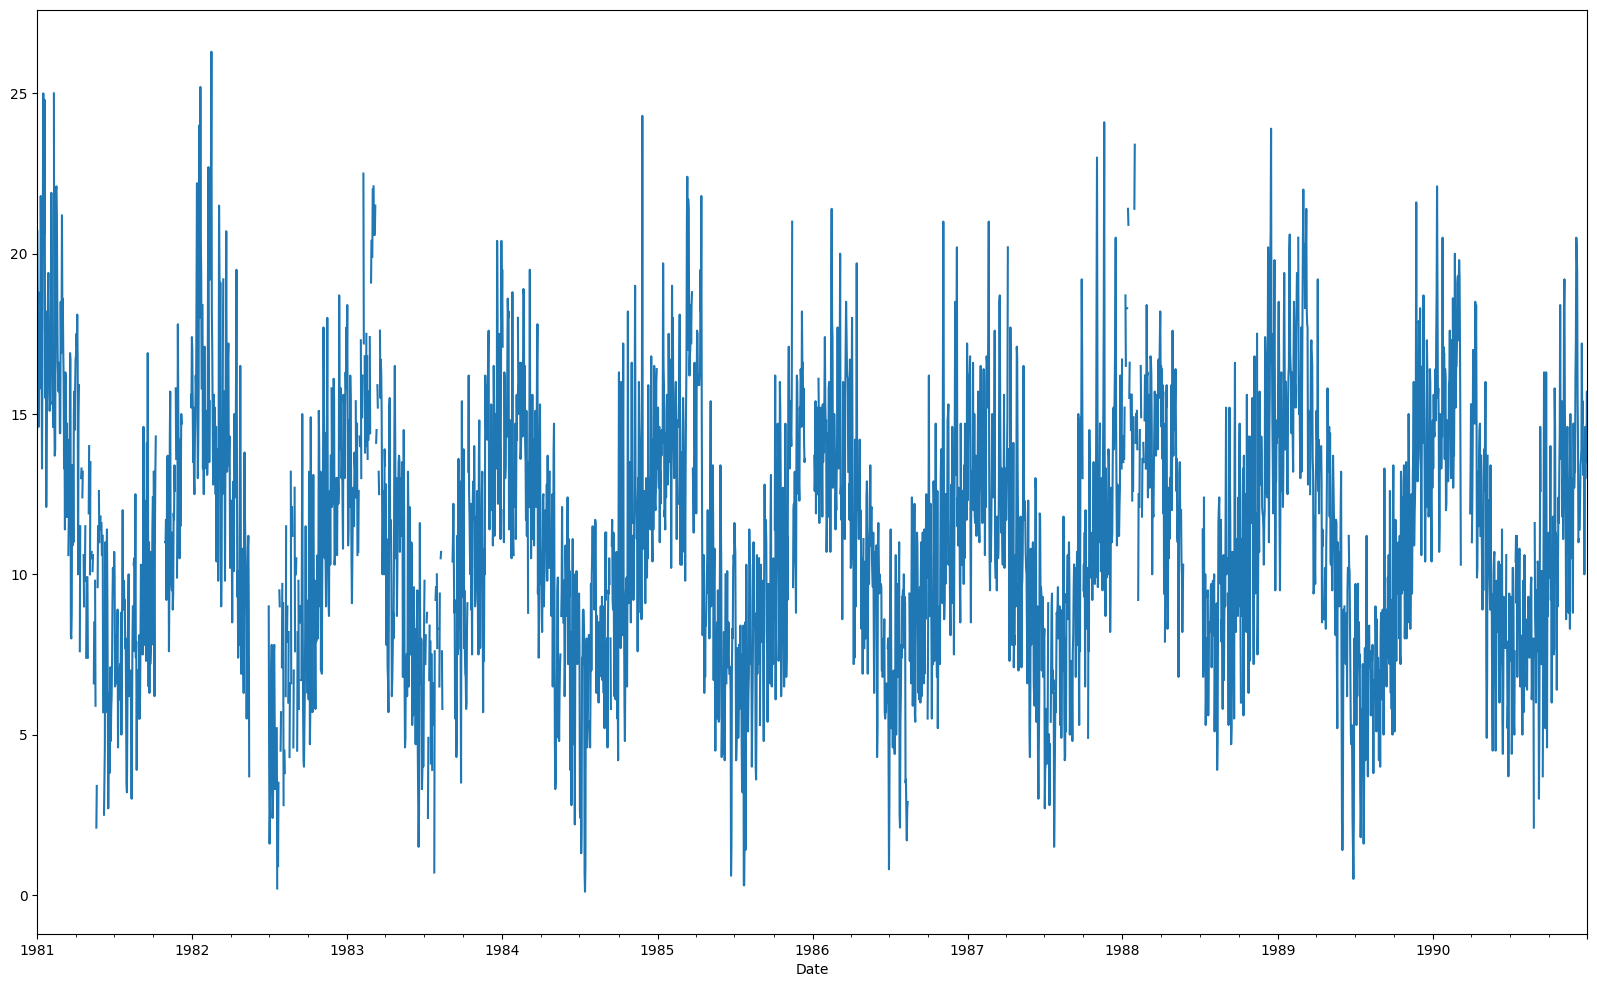

In [18]:
porcentaje = 0.1
divisiones = 0.05

serie_nulos_mix = series.copy()

n_eliminar = int(len(series) * porcentaje)
n_eliminar_por_seccion = n_eliminar/4

# Seccion discontinua
np.random.seed(1) # para tener resultados repetibles

indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar_por_seccion*divisiones), replace=False)

for i in range (0, len(indices_a_eliminar)):
    inicio = serie_nulos_mix.index.get_loc(indices_a_eliminar[i])
    final = serie_nulos_mix.index.get_loc(indices_a_eliminar[i])+int(1/divisiones)*3
    if final>=len(serie_nulos_discontinuos):
        inicio -= int(1/divisiones)*3
        final -= int(1/divisiones)*3
    for j in range(inicio,final,3):
        serie_nulos_mix.iloc[j] = np.nan

# Seccion seguidos
np.random.seed(2) # para tener resultados repetibles

indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar_por_seccion*divisiones), replace=False)

for i in range (0, len(indices_a_eliminar)):
    inicio = serie_nulos_mix.index.get_loc(indices_a_eliminar[i])
    final = serie_nulos_mix.index.get_loc(indices_a_eliminar[i])+int(1/divisiones)+1
    if final >= len(serie_nulos_mix):
        inicio -= int(1/divisiones)+1
        final -= int(1/divisiones)+1
    serie_nulos_mix.iloc[inicio:final] = np.nan

# Seccion aleatoria
np.random.seed(3) # para tener resultados repetibles
indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar_por_seccion), replace=False)

serie_nulos_mix.loc[indices_a_eliminar] = np.nan

# Seccion inicio fin
serie_nulos_mix.iloc[500:500+int(n_eliminar_por_seccion/2)] = np.nan # Eliminar unos datos del inicio
serie_nulos_mix.iloc[2700:2700+int(n_eliminar_por_seccion/2)] = np.nan # Eliminar unos datos del final

serie_nulos_mix.plot(figsize=(20,12))
plt.show()

In [19]:
serie_nulos_mix[serie_nulos_mix.isna()]

Date
1981-02-08   NaN
1981-03-11   NaN
1981-03-14   NaN
1981-04-10   NaN
1981-04-13   NaN
              ..
1990-07-14   NaN
1990-08-28   NaN
1990-09-13   NaN
1990-09-16   NaN
1990-12-12   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 376, dtype: float64

In [20]:
n_eliminar_por_seccion

91.25